# 1. Setup

In [3]:
# !pip3 install pandas
# !pip3 install numpy
# !pip3 install seaborn
# !pip install matplotlib

  Using cached pandas-2.0.3-cp38-cp38-macosx_11_0_arm64.whl (10.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 2.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 kB 9.4 MB/s eta 0:00:00a 0:00:01
  Using cached numpy-1.24.4-cp38-cp38-macosx_11_0_arm64.whl (13.8 MB)

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 10.7 MB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp38-cp38-macosx_11_0_arm64.whl (66 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.1 MB/s eta 0:00:00
  Using cached contourpy-1.1.1-cp38-cp38-macosx_11_0_arm64.whl (232 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

# 2. Data Cleaning

Quick summary:
- dropped rows where Quantity < 0, UnitPrice < 0
- dropped rows that could be considered as 'lost capital' (see Section 2.4)

In [74]:
# %ls
df = pd.read_csv('data.csv', encoding='ISO-8859-1') 

## 2.1 Quick Look

In [7]:
df.shape

(541909, 8)

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

convert `InvoiceDate` into a `datetime` col

In [146]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

convert `InvoiceNo` to int

In [140]:
df['InvoiceNo'] = df['InvoiceNo'].astype(int)

## 2.2 `StockCode`

let's get some understanding around how `StockCode` works

In [75]:
tmp = df.copy()
tmp = tmp[tmp['StockCode'].str.isalpha()]
# tmp = df[(df['Quantity'] < 0) &  (~df['StockCode'].str.isnumeric()) ]
tmp['CodeAbb'] = tmp['StockCode'].str[-1]

In [95]:
codeAbb_dct = {}

for letter in tmp['CodeAbb'].unique().tolist():
    best_guess = tmp[tmp['CodeAbb']==letter]['Description'].mode()
    if len(best_guess) > 0:
        best_guess = best_guess[0]
    else:
        best_guess = ''
    print(f"{letter}: {best_guess}")

    codeAbb_dct[letter] = best_guess

: JUMBO BAG RED RETROSPOT
T: DOTCOM POSTAGE
M: Manual
S: SAMPLES
E: AMAZON FEE
m: Manual
Y: BOYS PARTY BAG
L: GIRLS PARTY BAG
B: Adjust bad debt


## 2.3 `Quantity` & `UnitPrice` 

In [6]:
df[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


rows with `UnitPrice` < 0 looks like book keeping adjustments, instead of actual customer purchasing records

In [31]:
df[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


`Quantity` < 0 also looks non-usable.

In [32]:
df[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


let's flag these "special" rows first.

In [85]:
df['special'] = False
df['special'] = np.where(
    (df['UnitPrice'] < 0) | (df['Quantity'] < 0),
    True,
    False
)

In [103]:
special_pct = round(df[df['special']==True].shape[0]/df.shape[0]*100,2)
print(f'{special_pct}% of the rows are special')

1.96% of the rows are special


These special rows are either erroneous or they can't give us useful purchasing info. 

<font color='coral'>Let's drop them</font>

In [104]:
df = df[df['special']==False]

## 2.4 NAs

add a `CodeAbb` col to the original `df` too

In [105]:
df['CodeAbb'] = ''
df['CodeAbb'] = np.where(
    df['StockCode'].str.isalpha(),
    df['StockCode'].str[-1],
    df['CodeAbb']
)

In [106]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133359
Country             0
CodeAbb             0
special             0
dtype: int64

In [111]:
customerId_null_pct = round(100*df.isnull()['CustomerID'].sum() / df.shape[0],2)
dscpt_null_pct = round(100*df.isnull()['Description'].sum() / df.shape[0],2)

print(f"{customerId_null_pct}% customerIDs are null.")
print(f"{dscpt_null_pct}% descriptions are null.")

25.1% customerIDs are null.
0.11% descriptions are null.


In [107]:
df[df['CustomerID'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CodeAbb,special
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom,,False
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom,,False
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom,,False
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom,,False
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom,,False


In [112]:
tmp = df[df['CustomerID'].isnull()]
tmp[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,133359.000000,133359.000000
mean,3.593931,6.234654
std,28.123721,60.526575
min,1.000000,0.000000
25%,1.000000,1.630000
50%,1.000000,3.290000
75%,3.000000,5.790000
max,5568.000000,13541.330000


In [113]:
tmp[tmp['Description'].isnull()].shape

(592, 10)

DOTCOM Postage, Amazon fee, samples, adjust bad debt could be considered as 'lost capital'.

In [128]:
tmp = df.copy()
tmp = tmp[tmp['CustomerID'].isnull()]['CodeAbb'].value_counts().reset_index()
tmp['CodeBestGuess'] = tmp['CodeAbb'].replace(codeAbb_dct)

tmp

,CodeAbb,count,CodeBestGuess
0,,132568,JUMBO BAG RED RETROSPOT
1,T,724,DOTCOM POSTAGE
2,M,37,Manual
3,L,13,GIRLS PARTY BAG
4,Y,11,BOYS PARTY BAG
5,E,2,AMAZON FEE
6,S,2,SAMPLES
7,m,1,Manual
8,B,1,Adjust bad debt


<font color='coral'>Let's drop them.</font>

In [129]:
df = df[~df['CodeAbb'].isin(['T', 'E', 'S', 'B'])]

common description for rows with no customerID?

In [130]:
df[df['CustomerID'].isnull()]['Description'].value_counts()[:20]

Description
JUMBO BAG RED RETROSPOT               497
JUMBO STORAGE BAG SUKI                414
JUMBO SHOPPER VINTAGE RED PAISLEY     387
JUMBO BAG WOODLAND ANIMALS            372
JUMBO BAG PINK POLKADOT               348
RECYCLING BAG RETROSPOT               341
RED TOADSTOOL LED NIGHT LIGHT         327
SUKI  SHOULDER BAG                    326
GREEN REGENCY TEACUP AND SAUCER       324
PARTY BUNTING                         310
WOODLAND CHARLOTTE BAG                304
PACK OF 72 RETROSPOT CAKE CASES       302
RED RETROSPOT CHARLOTTE BAG           301
CHARLOTTE BAG SUKI DESIGN             300
WHITE HANGING HEART T-LIGHT HOLDER    299
REGENCY CAKESTAND 3 TIER              295
JAM MAKING SET PRINTED                294
RECIPE BOX PANTRY YELLOW DESIGN       290
JUMBO  BAG BAROQUE BLACK WHITE        287
NATURAL SLATE HEART CHALKBOARD        283
Name: count, dtype: int64

In [133]:
df[df['CustomerID'].isnull()]['InvoiceDate'].describe()

count               132630
unique                1908
top       10/31/2011 14:41
freq                  1113
Name: InvoiceDate, dtype: object

In [148]:
df['year_month'] = df['InvoiceDate'].dt.to_period('M')


towards the end of the year there tends to be big spikes in null customerIDs

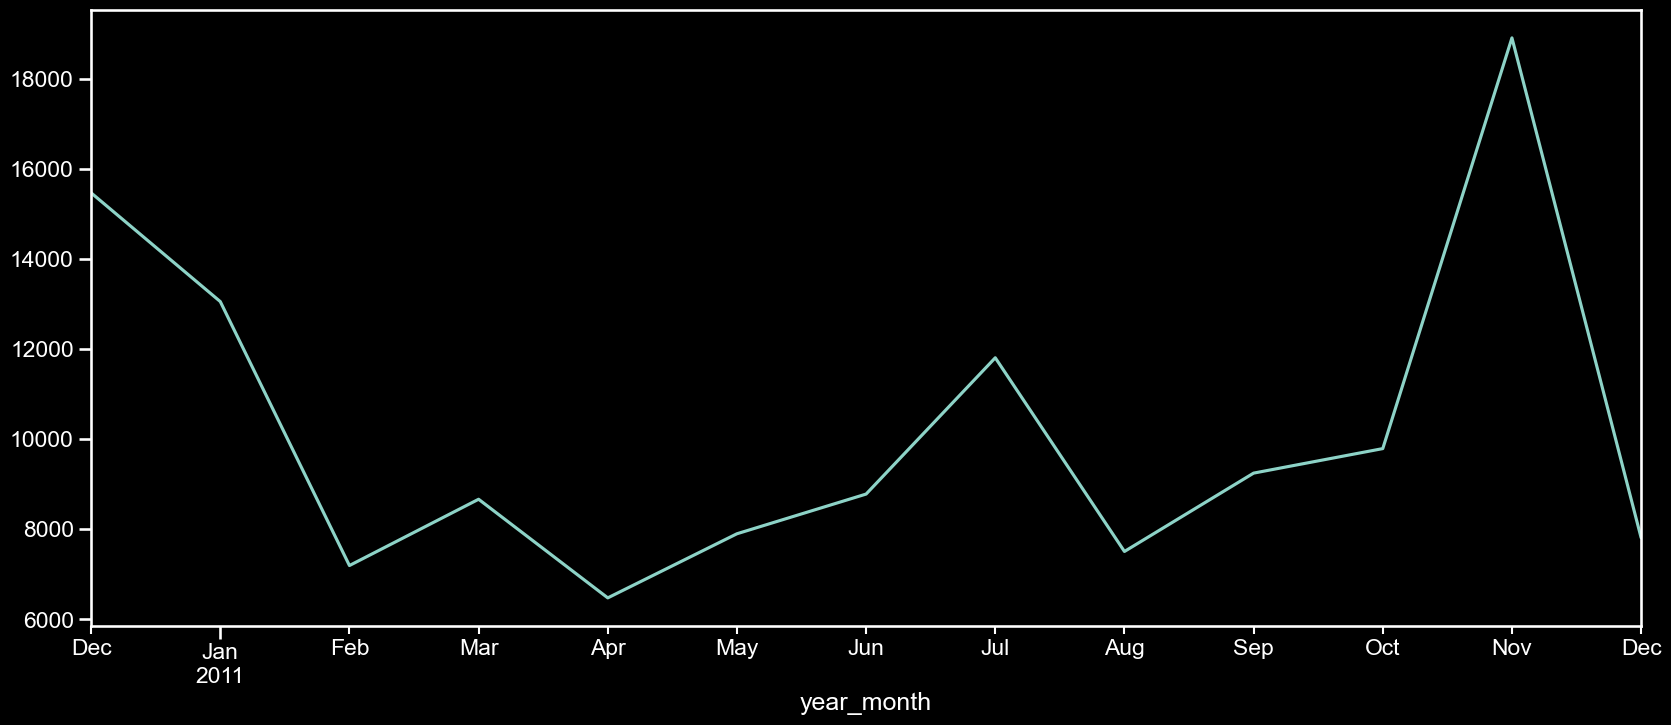

In [172]:
tmp = df[['CustomerID', 'year_month', 'InvoiceNo']]
tmp = tmp[tmp['CustomerID'].isnull()]
tmp = tmp.groupby('year_month').count().reset_index().set_index('year_month')


sns.set(style="ticks", context="talk", rc = {'figure.figsize':(20,8)})
plt.style.use("dark_background")

tmp['InvoiceNo'].plot();

# Countries

# Customers

# Reference

- [dataset](https://www.kaggle.com/datasets/carrie1/ecommerce-data)
- [Kaggle notebook: ecommerce sales forecast](https://www.kaggle.com/code/allunia/e-commerce-sales-forecast)
- [Customer Segmentation](https://www.kaggle.com/code/fabiendaniel/customer-segmentation)